In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt 
from scipy import interpolate
import pandas as pd
import random
import numpy as np
import os 
import math
import torch

import copy
import time
import math

import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

from torch.utils.tensorboard import SummaryWriter
torch.set_default_dtype(torch.float)

import mads_dl
torch.set_default_dtype(torch.float)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
import torch.nn as nn
import mads_dl




# Step 1: Loading the data

In [2]:
# load the data
def load_data():
    path_list = []
    cwd = Path(os.getcwd())
    print(f'Working Dir: {cwd}')
    data_path = os.path.join(cwd.parent, 'Data')

    print(f'Path: {data_path}')
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('FA_20231113_2H_yeast_Pyruvate-d3_1.csv'):
                file_path = os.path.join(root, file)
                path_list.append(file_path)
    return path_list
# FA_20231113_2H_yeast_Pyruvate-d3_1.csv

path_list = load_data()
print(path_list)

Working Dir: d:\Dokumente\MoinCC-AI4metabolomics\NMRQNet
Path: d:\Dokumente\MoinCC-AI4metabolomics\Data
['d:\\Dokumente\\MoinCC-AI4metabolomics\\Data\\FA_20231113_2H_yeast_Pyruvate-d3_1.csv']


In [3]:
for file in path_list:
    df = pd.read_csv(file)
    print(df.shape)

(1503, 131)


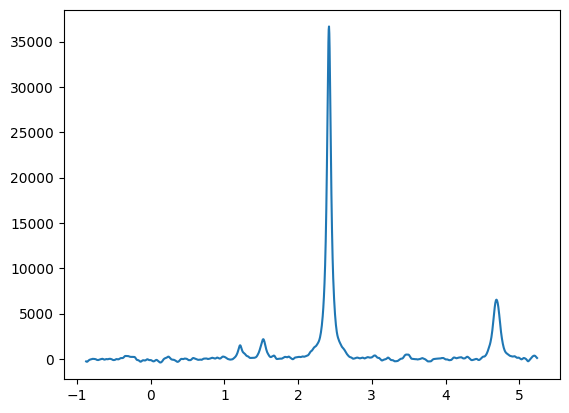

In [4]:
for i in range(len(path_list)):
    df = pd.read_csv(path_list[i])
    df['sum'] = df.iloc[:,1:].sum(axis=1)

    x = df.iloc[:,0]
    y = df.iloc[:, 1]

    #print(df.shape)

    plt.plot(x,y)


plt.show()

In [5]:
df['sum']

0       -852.953510
1      -1168.218890
2      -1524.973790
3      -1905.063789
4      -2313.660113
           ...     
1498    6968.597040
1499    6811.509176
1500    6645.824694
1501    6291.822860
1502    5931.063100
Name: sum, Length: 1503, dtype: float64

# Step 2: Generating synthetic Data for - FA_20231113_2H_yeast_Pyruvate-d3_1.csv

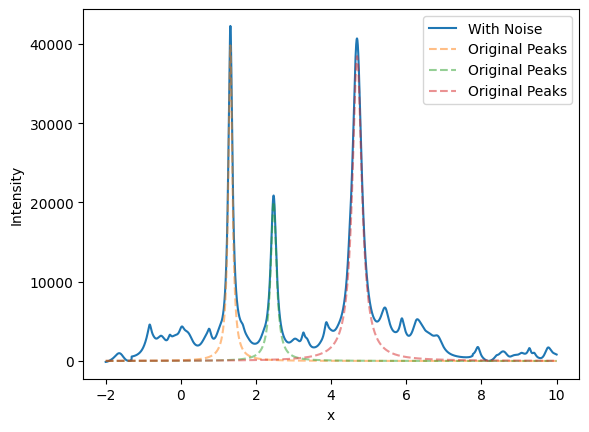

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Lorentzian function
def lorentzian(x, x0, gamma, height):
    return height * (gamma**2 / ((x - x0)**2 + gamma**2))


def generate_random_spectrum(peak_list, spectrum_length=5000):
    # Generate random spectrum with Lorentzian peaks
    x = np.linspace(-2, 10, spectrum_length)  # x range
    y = np.zeros_like(x)          # initialize y as zeros
    mask = np.zeros_like(x)       # mask to identify peak regions

    # Add random Lorentzian peaks
    #np.random.seed(0)
    x0_parms = []
    gamma_parms = []
    height_parms = []
    for peak_pos in peak_list:
        metabolism_x0 = peak_pos + np.random.uniform(-0.1, 0.1)
        #print(x0) 
        metabolism_gamma = np.random.uniform(0.05, 0.2)  # Random width (gamma)
        metabolism_height = np.random.uniform(0, 40000)  # Random height
        peak_lorenz = lorentzian(x, metabolism_x0, metabolism_gamma, metabolism_height)
        y += peak_lorenz

        
        # Add more peaks with lower height
        # create random integer between 1 and 8
        num_peaks = np.random.randint(1, 5)
        for _ in range(num_peaks):
            for _ in range(8):
                x0 = np.random.uniform(-2, 10)
                gamma = np.random.uniform(0.05, 0.2)
                height = np.random.uniform(0, 2000)
                y += lorentzian(x, x0, gamma, height)

        # Create a mask to identify regions near the peaks (exclude noise here)
        mask += peak_lorenz > (0.1 * height)  # Masking regions where peak height is significant

        # Append the parameters for the peak
        x0_parms.append(metabolism_x0)
        gamma_parms.append(metabolism_gamma)
        height_parms.append(metabolism_height)
        

    # Add noise only outside the peak regions
    random_noise_level = np.random.uniform(100, spectrum_length)
    noise = np.random.normal(10, random_noise_level, spectrum_length)

    # smooth the noise with gaussian filter
    sigma = random_noise_level / 100
    noise = gaussian_filter1d(noise, sigma=sigma)
        
    y_noisy = y + noise * (mask == 0)  # Add noise only where mask is 0 (outside peaks)

    return x, y_noisy, np.array(x0_parms), np.array(gamma_parms), np.array(height_parms)


# ----

#peak_list = [2.323, 4.7, 1.201]
pyruvate_list = [1.2261, 2.468, 4.7]
x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(pyruvate_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise")

for x0, gamma, height in zip(x0_parms, gamma_parms, height_parms):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label="Original Peaks", alpha=0.5)  
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()


# Step 3: Fill Up Original Data 

          x           y
0 -2.000000 -138.873661
1 -1.995927 -139.368203
2 -1.991855 -137.844466
3 -1.987782 -131.107547
4 -1.983710 -117.675398


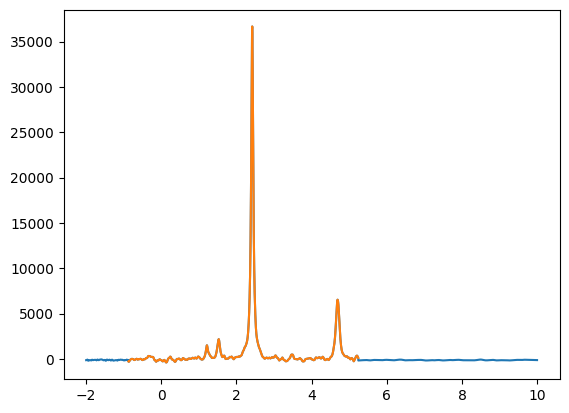

(2949, 2)


In [7]:



def interpolate_to_shape(x_original, y_original, spectrum_lenth=5000):
    """_summary_

    # Originaldaten
    y_original = df.iloc[:, 1]
    x_original = df.iloc[:, 0]

    Args:
        df (_type_): _description_
    """


    # Neue x-Werte (stellen Sie sicher, dass diese innerhalb des Bereichs von x_original liegen)
    x_new = np.linspace(x_original.min(), x_original.max(), spectrum_lenth)

    # Interpolierte Daten
    interpolated_data = interpolate.interp1d(x_original, y_original, kind='linear')(x_new)
    
    df = pd.DataFrame({'x': x_new, 'y': interpolated_data})
    return df

def fill_df(df):
    """If Data is not ranging from -2 to 10, fill the data with noise
    
    """
    # renmame the columns
    df.columns = ['x', 'y']
    x = df.loc[:, 'x']
    y = df.loc[:, 'y']



    # Calculate the step size of the x values
    x_diff = np.diff(x)
    step = np.mean(x_diff)
    
    # Take sample range for the noise
    x_range_lower = 20
    x_range_upper = 100

    # get sample data of the noise
    x_sample = x[x_range_lower:x_range_upper]
    y_sample = y[x_range_lower:x_range_upper]

    # get the max and min values of the sample data
    y_min, y_max = y_sample.min(), abs(y_sample.min())
    x_min, x_max = x_sample.min(), abs(x_sample.min())

    if x_min > -2:

        # create values in n steps
        x_new = np.arange(-2, x.iloc[0], step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(y_min, y_max, len(x_new))
        
        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([data, df], axis=0)
        df.reset_index(drop=True, inplace=True)

    if x_max < 10:
    
        # create values in n steps
        x_new = np.arange(x.iloc[-1], 10, step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(y_min, y_max, len(x_new))

        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([df, data], axis=0)
        df.reset_index(drop=True, inplace=True)
                
    return df


df_fill = df.iloc[:, 0:2]
#print(df_fill.head())
df_filled = fill_df(df_fill)
print(df_filled.head())

# plot 
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1])
plt.show()
print(df_filled.shape)


# Step 3: Bring data to same shape

(5000, 2)


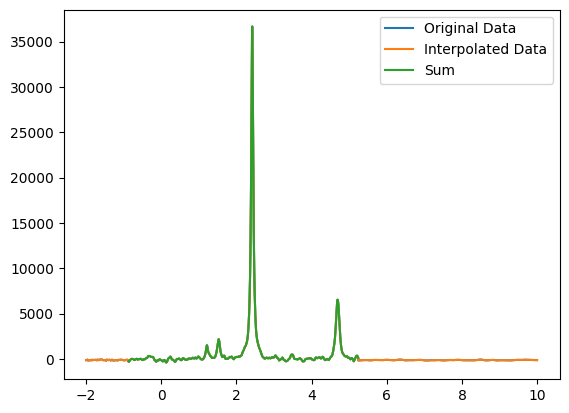

In [8]:

# Interpoliere die Werte, um die Größe des DataFrames zu erweitern
df_interpolated = interpolate_to_shape(df_filled.iloc[:, 0], df_filled.iloc[:, 1], spectrum_lenth=5000)

# Form des interpolierten DataFrames
print(df_interpolated.shape)

# Plot the interpolated data
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1])
plt.plot(df.iloc[:, 0], df.iloc[:, 1])
plt.legend(['Original Data', 'Interpolated Data', 'Sum'])
plt.show()

# Step 4: Bring Data to shape for Transformer

In [9]:
df_interpolated.shape

(5000, 2)

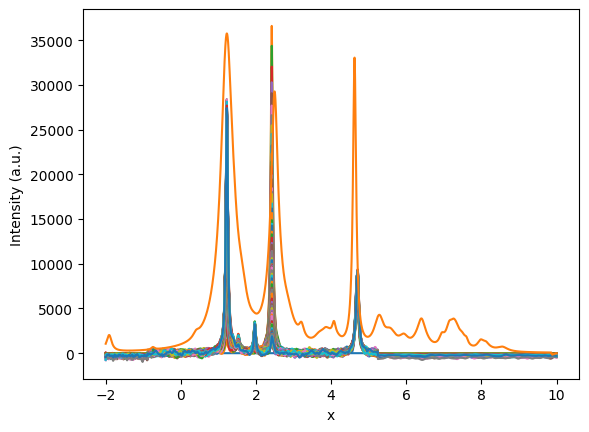

In [10]:
for i in range(df.shape[1]-1):

    df_filled = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_filled.loc[:,'x'], df_filled.loc[:,'y'], spectrum_lenth=5000)
    #plt.plot(df_filled.loc[:,'x'], df_filled.loc[:,'y'], '-', label='Original Data')
    plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], '-', label='Interpolated Data')

# data_train_tensor & y_train
pyruvate_list = [2.468, 4.7, 1.2261]
x_synth, y_synth, x0_parms, gamma_parms, height_parms = generate_random_spectrum(pyruvate_list)


plt.plot(x_synth, y_synth, label="With Noise")
plt.xlabel('x')
plt.ylabel('Intensity (a.u.)')

plt.show()

# Generate training Dataset 

In [11]:

num_samples = 10000

x_data = []
y_data = []
x0_parms_list = []
gamma_parms_list = []
height_parms_list = []
for i in range(num_samples):
    # data_train_tensor & y_train
    pyruvate_list = [2.468, 4.7, 1.2261]
    x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(pyruvate_list)
    x_data.append(x)
    y_data.append(y_noisy)
    x0_parms_list.append(x0_parms)
    gamma_parms_list.append(gamma_parms)
    height_parms_list.append(height_parms)




# Umwandeln der lists in Tensoren
x_data = torch.tensor(x_data)
data = torch.tensor(y_data) # Data: Noisy Spectra which is input to the model
x_params_tensor = torch.tensor(x0_parms_list) # Target: 
gamma_params_tensor = torch.tensor(gamma_parms_list)
height_params_tensor = torch.tensor(height_parms_list)

target = torch.cat((x_params_tensor, gamma_params_tensor, height_params_tensor), dim=1)



# Überprüfen der Formen
print(f"x_data shape: {x_data.shape}")
print(f"data shape: {data.shape}")
print(f"x_params_tensor shape: {x_params_tensor.shape}")
print(f"gamma_params_tensor shape: {gamma_params_tensor.shape}")
print(f"height_params_tensor shape: {height_params_tensor.shape}")
print(f"target shape: {target.shape}")
print('\n')

C:\Users\Gener\AppData\Local\Temp\ipykernel_18992\781391728.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  x_data = torch.tensor(x_data)


x_data shape: torch.Size([10000, 5000])
data shape: torch.Size([10000, 5000])
x_params_tensor shape: torch.Size([10000, 3])
gamma_params_tensor shape: torch.Size([10000, 3])
height_params_tensor shape: torch.Size([10000, 3])
target shape: torch.Size([10000, 9])




In [12]:
def scale_data(data, target):
    """Scale the data
    
    Args:
        x_data (_type_): _description_
        y_data (_type_): _description_
    """
    # Skalieren Sie die Daten
    data_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    print(f'Before Scaling: {data.shape}')
    print(f'Before Scaling: {target.shape}')

    # Reshape the data before scaling
    data = data.reshape(data.shape[0], -1)
    target = target.reshape(target.shape[0], -1)

    print(f'After Reshaping: {data.shape}')
    print(f'After Reshaping: {target.shape}')

    # Skalieren Sie die x-Daten
    data_scaled = data_scaler.fit_transform(data)
    target_scaled = target_scaler.fit_transform(target)
    
    print(f'After Scaling: {data_scaled.shape}')
    print(f'After Scaling: {target_scaled.shape}')


    return data_scaled, target_scaled, data_scaler, target_scaler
    

# Skalieren Sie die Daten
data_scaled, target_scaled, data_scaler, target_scaler = scale_data(data, target)

Before Scaling: torch.Size([10000, 5000])
Before Scaling: torch.Size([10000, 9])
After Reshaping: torch.Size([10000, 5000])
After Reshaping: torch.Size([10000, 9])
After Scaling: (10000, 5000)
After Scaling: (10000, 9)


In [13]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Aufteilen der Daten in Trainings- und Testsets
data_train, data_test, target_train, target_test = train_test_split(data, target, 
                                                    test_size=0.4,
                                                    shuffle=True,
                                                    random_state=1)

# Skalieren der Daten
data_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Skalieren von data train und test
data_train_sc = data_scaler.fit_transform(data_train.reshape(data_train.shape[0], -1))
data_test_sc = data_scaler.transform(data_test.reshape(data_test.shape[0], -1))

# Skalieren von target train und test
target_train_sc = target_scaler.fit_transform(target_train.reshape(target_train.shape[0], -1))
target_test_sc = target_scaler.transform(target_test.reshape(target_test.shape[0], -1))


# Konvertieren in Tensoren
data_train_tensor = torch.Tensor(data_train_sc)
data_test_tensor = torch.Tensor(data_test_sc)
target_train_tensor = torch.Tensor(target_train_sc)
target_test_tensor = torch.Tensor(target_test_sc)


# Reshape the tensors for the model
target_train_tensor = target_train_tensor.reshape(target_train_tensor.shape[0], -1)
target_test_tensor = target_test_tensor.reshape(target_test_tensor.shape[0], -1)

# Überprüfen der Tensoren
print(f"Data Train Shape: {data_train_tensor.shape}")
print(f"Data Test Shape: {data_test_tensor.shape}")
print(f"Target Train Shape: {target_train_tensor.shape}")
print(f"Target Test Shape: {target_test_tensor.shape}")

Data Train Shape: torch.Size([6000, 5000])
Data Test Shape: torch.Size([4000, 5000])
Target Train Shape: torch.Size([6000, 9])
Target Test Shape: torch.Size([4000, 9])


## Implementing Multilayer Network

In [34]:
print(f"Verwende Gerät: {device}")

criterion = torch.nn.MSELoss().to(device)
learning_rate=0.01
epochs=3000

# Daten auf die GPU verschieben
data_train_tensor = data_train_tensor.to(device)
data_test_tensor = data_test_tensor.to(device)
target_train_tensor = target_train_tensor.to(device)
target_test_tensor = target_test_tensor.to(device)



Verwende Gerät: cuda


In [35]:
# MultiLayerPerceptron-Modell
import torch.nn as nn
import torch.optim as optim

class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(MultiLayerPerceptron, self).__init__()
                
        self.hidden_1 = nn.Linear(input_size, int(input_size/2))
        self.hidden_2 = nn.Linear(int(input_size/2), int(input_size/10))
        self.hidden_3 = nn.Linear(int(input_size/10), int(input_size/30))
        self.hidden_4 = nn.Linear(int(input_size/30), int(input_size/50))
        self.hidden_5 = nn.Linear(int(input_size/50), int(input_size/70))
        self.hidden_6 = nn.Linear(int(input_size/70), int(input_size/100))
        self.hidden_7 = nn.Linear(int(input_size/100), int(input_size/200))
        self.output = nn.Linear(int(input_size/200), output_size) # 3 parameters per peak
        self.activation=nn.PReLU()
 
    def forward(self, x):
        # if len(x.shape) >2:
        #     x = x.reshape(x.shape[0], -1)

        out1 = self.activation(self.hidden_1(x))
        out2 = self.activation(self.hidden_2(out1))
        out3 = self.activation(self.hidden_3(out2))
        out4 = self.activation(self.hidden_4(out3))
        out5 = self.activation(self.hidden_5(out4))
        out6 = self.activation(self.hidden_6(out5))
        out7 = self.activation(self.hidden_7(out6))
        
        
        return self.output(out7)

In [36]:

# Modell initialisieren
input_size = data_train_tensor.shape[1]
hidden_size = 512
output_size = len(pyruvate_list)*3  # Da wir 3 Targets mit 10000 Features haben
model = MultiLayerPerceptron(input_size, hidden_size, output_size).to(device)

# Loss und Optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


print(f'Input Size: {input_size}')
print(f'Output Size: {output_size}')

Input Size: 5000
Output Size: 9


In [37]:
# Training function
def train_model(model, data_train_tensor, target_train_tensor, criterion, optimizer, epochs, device):
    model.train()
    model.to(device)
    data_train_tensor = data_train_tensor.to(device)
    target_train_tensor = target_train_tensor.to(device)

    for epoch in range(epochs):
        target_train_pred = model(data_train_tensor)
        optimizer.zero_grad()
        # print(target_train_pred.shape)
        # print(target_train_tensor.shape)
        train_loss = criterion(target_train_pred, target_train_tensor.reshape(target_train_tensor.shape[0], -1))
        
        train_loss.backward()

        optimizer.step()

        if (epoch % 100==99):
            print("Epoch: %d, loss: %1.5f" % (epoch, train_loss.item()))

In [38]:
train_model(model, data_train_tensor, target_train_tensor, criterion, optimizer, epochs, device)

Epoch: 99, loss: 0.06353
Epoch: 199, loss: 0.03514
Epoch: 299, loss: 0.02827
Epoch: 399, loss: 0.01455
Epoch: 499, loss: 0.01143
Epoch: 599, loss: 0.01020
Epoch: 699, loss: 0.01080
Epoch: 799, loss: 0.01143
Epoch: 899, loss: 0.00703
Epoch: 999, loss: 0.00678
Epoch: 1099, loss: 0.00538
Epoch: 1199, loss: 0.00509
Epoch: 1299, loss: 0.00372
Epoch: 1399, loss: 0.00309
Epoch: 1499, loss: 0.00333
Epoch: 1599, loss: 0.00342
Epoch: 1699, loss: 0.00189
Epoch: 1799, loss: 0.00155
Epoch: 1899, loss: 0.00161
Epoch: 1999, loss: 0.00176
Epoch: 2099, loss: 0.00176
Epoch: 2199, loss: 0.00211
Epoch: 2299, loss: 0.00057
Epoch: 2399, loss: 0.00053
Epoch: 2499, loss: 0.01589
Epoch: 2599, loss: 0.00227
Epoch: 2699, loss: 0.00127
Epoch: 2799, loss: 0.00157
Epoch: 2899, loss: 0.00159
Epoch: 2999, loss: 0.00076


In [39]:
def predict(model, X):
    '''
    Use the model to predict for the values in the test set.
    Return the prediction
    '''
    model.eval()
    with torch.no_grad():
        return model(X)

In [40]:
# # Bring all tensors back to the CPU
# data_train_tensor = data_train_tensor.to("cpu")
# data_test_tensor = data_test_tensor.to("cpu")

data_train_tensor.shape

torch.Size([6000, 5000])

In [41]:
# Vorhersagen und Rückskalierung
target_train_pred = predict(model, data_train_tensor)
target_test_pred = predict(model, data_test_tensor)

# Bring all tensors back to the CPU and to numpy
target_train_pred = target_train_pred.cpu().detach().numpy()
target_test_pred = target_test_pred.cpu().detach().numpy()

print(f'target_train_pred: {target_train_pred.shape}')
print(f'target_test_pred: {target_test_pred.shape}')



# Rescale the data
target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred)
target_test_pred_rescaled = target_scaler.inverse_transform(target_test_pred)

# Reshape the data
target_train_pred = target_train_pred_rescaled.reshape(target_train_pred_rescaled.shape[0], -1)
target_test_pred = target_test_pred_rescaled.reshape(target_test_pred_rescaled.shape[0], -1)




print(f'target_train_pred_rescaled: {target_train_pred.shape}')
print(f'target_test_pred_rescaled: {target_test_pred.shape}')

target_train_pred: (6000, 9)
target_test_pred: (4000, 9)
target_train_pred_rescaled: (6000, 9)
target_test_pred_rescaled: (4000, 9)


In [44]:
x

0      -0.875245
1      -0.871173
2      -0.867100
3      -0.863028
4      -0.858955
          ...   
1498    5.225390
1499    5.229470
1500    5.233540
1501    5.237610
1502    5.241680
Name: Unnamed: 0, Length: 1503, dtype: float64

data_train: (6000, 5000)
data_test: (4000, 5000)
target_train: (6000, 9)
target_test: (4000, 9)


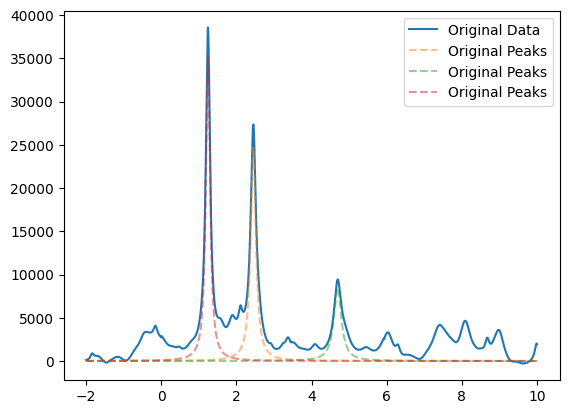

In [47]:
# bring the data back to the cpu
data_train_tensor = data_train_tensor.to("cpu")
data_test_tensor = data_test_tensor.to("cpu")
target_train_tensor = target_train_tensor.to("cpu")
target_test_tensor = target_test_tensor.to("cpu")

# scale the data back
data_train = data_scaler.inverse_transform(data_train_tensor)
data_test = data_scaler.inverse_transform(data_test_tensor)
target_train = target_scaler.inverse_transform(target_train_tensor.reshape(target_train_tensor.shape[0], -1))
target_test = target_scaler.inverse_transform(target_test_tensor.reshape(target_test_tensor.shape[0], -1))

print(f'data_train: {data_train.shape}')
print(f'data_test: {data_test.shape}')
print(f'target_train: {target_train.shape}')
print(f'target_test: {target_test.shape}')


x0_parms_train, gamma_parms_train, height_parms_train = np.split(target_train, 3, axis=1)
x0_parms_test, gamma_parms_test, height_parms_test = np.split(target_test, 3, axis=1)



n = 10
x = x_data[n]
# plot the data
plt.plot(x, data_train[n, :], '-', label='Original Data')
for x0, gamma, height in zip(x0_parms_train[n], gamma_parms_train[n], height_parms_train[n]):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)
    

plt.legend()
plt.show()

# Validate on real Data

In [48]:
# Use a dataframe to collect general evaluation results
results = pd.DataFrame()

# We will reuse this function. Hence we copy it to mads_dl.py
def add_regression_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred, num_params):
    '''
    Create a table with evaluation results
    of a regression experiment
    '''
    for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
        mse=mean_squared_error(actual, predicted)
        results= pd.concat([results, pd.DataFrame([{
            "algorithm": algorithm, 
            "dataset": dataset,
            "MSE": mse,
            "RMSE": math.sqrt(mse),
            "MAE": mean_absolute_error(actual, predicted),
            "MAPE": mean_absolute_percentage_error(actual, predicted)*100, # implemented is relative to 1 not to 100
            "params": num_params
        }])], ignore_index=True)   
    return results


# Test on Data

In [24]:
path_list

['d:\\Dokumente\\MoinCC-AI4metabolomics\\Data\\FA_20231113_2H_yeast_Pyruvate-d3_1.csv']

(1, 5000)


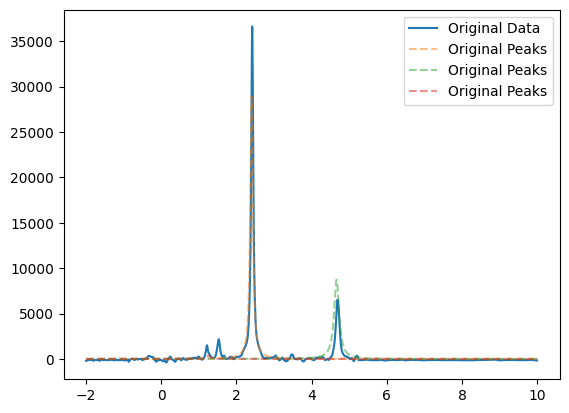

In [51]:
df = pd.read_csv(path_list[0]) 
df['sum'] = df.iloc[:,1:].sum(axis=1)
x = df.iloc[:,0]
y = df.iloc[:, 100]

# fill the data
df_fill = fill_df(df.iloc[:, 0:2])

# interpolate the data
df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=5000)

x_val = df_interpolated.iloc[:, 0]
y_val = df_interpolated.iloc[:, 1]

# scale the data
y_val_sc = data_scaler.transform(y_val.values.reshape(1, -1))
print(y_val_sc.shape)

# convert to tensor
y_val_tensor = torch.Tensor(y_val_sc).to(device)

# predict the data
target_val_pred = predict(model, y_val_tensor)

# bring the data back to the cpu
target_val_pred = target_val_pred.cpu().detach().numpy()

# rescale the data
target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred)

# reshape the data
target_val_pred = target_val_pred_rescaled.reshape(target_val_pred_rescaled.shape[0], -1)

x0_parms_val, gamma_parms_val, height_parms_val = np.split(target_val_pred, 3, axis=1)


# plot the data
plt.plot(x_val, y_val, '-', label='Original Data')
for x0, gamma, height in zip(x0_parms_val[0], gamma_parms_val[0], height_parms_val[0]):
    lorentz = lorentzian(x_val, x0, gamma, height)
    plt.plot(x_val, lorentz, '--', label='Original Peaks', alpha=0.5)
plt.legend()
plt.show()
